In [1]:
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(0)
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(2)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(24)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(26)

# 5. Configure a new global `tensorflow` session
#from keras import backend as K

from tensorflow.python.keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt   # plotting

from sklearn import preprocessing  #用來標準化刻度
from keras.models import Sequential
from keras.layers import Dense,Dropout  
from sklearn.model_selection import train_test_split
from keras.losses import logcosh, categorical_crossentropy
from keras.utils import to_categorical
from scipy import interp
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
# Import Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from time import time
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

####################################################################################  x_lstm_validation

T=22

train_cardiac_total=pd.read_csv("mimic_ca_vital_sign_train_"+str(T)+"hours.csv")
test_cardiac_total=pd.read_csv("mimic_ca_vital_sign_test_"+str(T)+"hours.csv")
train_cardiac_base_total=pd.read_csv("mimic_ca_baseline_total_v2.csv")

#eicu_cardiac_total=pd.read_csv("eicu_total_"+str(T)+"hours.csv")
eicu_cardiac_total=pd.read_csv("eicu_version2_"+str(T)+"hours.csv")

total_train=21540 #control+event
total_test=5384 #control+event
train_control=21160 #control

total_eicu=10049 #control+event

var=6
random=32
smote_ratio=1
near_ratio=1
EPOCH = 3                    # number of epochs
BATCH = 32                      # batch size

dropout=0.4
LR = 0.001                           # learning rate of the gradient descent
LAMBD = 0.001                       # lambda in L2 regularizaion

#####################################################################################
train_cardiac_base_total=train_cardiac_base_total.drop(['subject_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['hadm_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['stay_id'],axis=1)
train_cardiac_base_total=train_cardiac_base_total.drop(['los'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CA'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['hospDIED'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNR'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['CMO'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['DNRDNI'],axis=1)

#train_cardiac_base_total=train_cardiac_base_total.drop(['DNI'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['FullCode'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['indextime'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs9'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['ccs10'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['cardRv2'],axis=1)

###############CXR##############
#train_cardiac_base_total=train_cardiac_base_total.drop(['Atelectasis'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Cardiomegaly'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Consolidation'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Edema'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Enlarged Cardiomediastinum'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Fracture'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Lesion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Lung Opacity'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['No Finding'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Effusion'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pleural Other'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumonia'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Pneumothorax'],axis=1)
#train_cardiac_base_total=train_cardiac_base_total.drop(['Support Devices'],axis=1)
###############CXR##############

#train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity","BMI"])
train_cardiac_base_total=pd.get_dummies(data=train_cardiac_base_total,columns=["first_careunit","ethnicity"])


####################################################################
df_train_base=train_cardiac_base_total[:total_train]
y_train=df_train_base[['eventV3']].values   #取train_labels
y_train_nr=df_train_base[['eventV3']].values   #取train_labels
y_train_base=df_train_base[['eventV3']].values   #取train_labels
y_train_no_smote=df_train_base[['eventV3']].values   #取train_labels
df_train_base=df_train_base.drop(['eventV3'],axis=1)
train_features=df_train_base.values

df_test_base=train_cardiac_base_total[total_train:]
y_test=df_test_base[['eventV3']].values   #取test_labels
y_test_log=df_test_base['eventV3'].values   #取test_labels
df_test_base=df_test_base.drop(['eventV3'],axis=1)
test_features=df_test_base.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_train_base=minmax_scale.fit_transform(train_features)
x_test_base=minmax_scale.fit_transform(test_features)

x_train_base_no_smote=minmax_scale.fit_transform(train_features)
#x_train_base=train_features
#x_test_base=test_features

sm = SMOTE(random_state=random, sampling_strategy=smote_ratio)
nr = NearMiss(sampling_strategy=near_ratio) 

x_train_base, y_train_base = sm.fit_sample(x_train_base, y_train_base.ravel())
#x_train_base, y_train_base = nr.fit_sample(x_train_base, y_train_base.ravel())

train_cardiac_total=train_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']]    
train_cardiac_total=np.array(train_cardiac_total).reshape(total_train,T*var) #轉二維  array
train_cardiac_total= pd.DataFrame(train_cardiac_total)

x_test_lstm=test_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 
#x_test_lstm=minmax_scale.fit_transform(x_test_lstm)  #規一化
x_test_lstm=np.array(x_test_lstm).reshape(total_test,T,var) 

x_train_lstm, y_train = sm.fit_sample(train_cardiac_total, y_train.ravel())

x_train_lstm_nr, y_train_nr = nr.fit_sample(train_cardiac_total, y_train_nr.ravel())

#x_train_lstm=minmax_scale.fit_transform(x_train_lstm)  #規一化

x_train_lstm=np.array(x_train_lstm).reshape(x_train_lstm.shape[0],T,var) #轉三維  total

x_train_lstm_nr=np.array(x_train_lstm_nr).reshape(x_train_lstm_nr.shape[0],T,var) #轉三維  total

x_train_lstm_no_smote=np.array(train_cardiac_total).reshape(train_cardiac_total.shape[0],T,var) #轉三維  total

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

print('timeline:',train_cardiac_total.shape)
print('baseline:',df_train_base.shape)

print('timeline:',x_train_lstm.shape)
print('baseline:',x_train_base.shape)
print('label:',y_train.shape)

print('timeline:',x_test_lstm.shape)
print('baseline:',x_test_base.shape)
print('label:',y_test.shape)

print('timeline_no_smote:',x_train_lstm_no_smote.shape)
print('baseline_no_smote:',x_train_base_no_smote.shape)
print('label_no_smote:',y_train_no_smote.shape)


print('timeline_nr:',x_train_lstm_nr.shape)
print('label_nr:',y_train_nr.shape)
#print(df_train_base.columns)


Using TensorFlow backend.


timeline: (21540, 132)
baseline: (21540, 70)
timeline: (42320, 22, 6)
baseline: (42320, 70)
label: (42320,)
timeline: (5384, 22, 6)
baseline: (5384, 70)
label: (5384, 1)
timeline_no_smote: (21540, 22, 6)
baseline_no_smote: (21540, 70)
label_no_smote: (21540, 1)
timeline_nr: (760, 22, 6)
label_nr: (760,)


In [2]:
print(x_train_lstm.shape)
print(y_train.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_smote = Sequential()

model_smote.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())

model_smote.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_smote.add(Dropout(dropout))
model_smote.add(BatchNormalization())


model_smote.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_smote.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_smote.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_smote.fit(x_train_lstm, y_train,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_smote.evaluate(x_train_lstm, y_train,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_smote.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(42320, 22, 6)
(42320,)
layers=[8, 8, 8, 1], train_examples=42320, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 8)             480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 8)             32        
_________________________________________________________________
lstm_2 (LSTM)                (None, 22, 8)             544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 8)             0         
_____________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 55s - loss: 0.5589 - accuracy: 0.7378 - f1_m: 0.5733 - precision_m: 0.7369 - val_loss: 0.6144 - val_accuracy: 0.6388 - val_f1_m: 0.7766 - val_precision_m: 1.0000
Epoch 3/3
 - 74s - loss: 0.5404 - accuracy: 0.7452 - f1_m: 0.5941 - precision_m: 0.7405 - val_loss: 0.7681 - val_accuracy: 0.5097 - val_f1_m: 0.6707 - val_precision_m: 1.0000
-----------------------------------------------------------------
Training was completed in 168.53 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 71.4319%
test accuracy = 90.8432%
test error = 493 out of 5384 examples


In [3]:
y_pred_smote= model_smote.predict(x_test_lstm)

predict_test_smote=[]
for i in range(y_pred_smote.shape[0]): 
    if y_pred_smote[i]>0.5:
        predict_test_smote.append(1)
    else:
        predict_test_smote.append(0)
predict_test_smote = np.array(predict_test_smote)
print(predict_test_smote)

[0 0 0 ... 1 0 0]


In [4]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_smote,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_smote)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
smote_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, smote_roc_auc = roc_curve_and_score(y_test, y_pred_smote)

smote_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
smote_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('smote_accuracy:%0.2f' %smote_accuracy)
print('smote_auc:  %0.2f' %smote_roc_auc)
print('smote_sensitivity : %0.2f' %smote_sensitivity)
print('smote_specificity : %0.2f' %smote_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4855  434]
 [  59   36]]
smote_accuracy:0.91
smote_auc:  0.72
smote_sensitivity : 0.38
smote_specificity : 0.92
ppv: 0.07659574468085106
npv: 0.987993487993488


<Figure size 432x288 with 0 Axes>

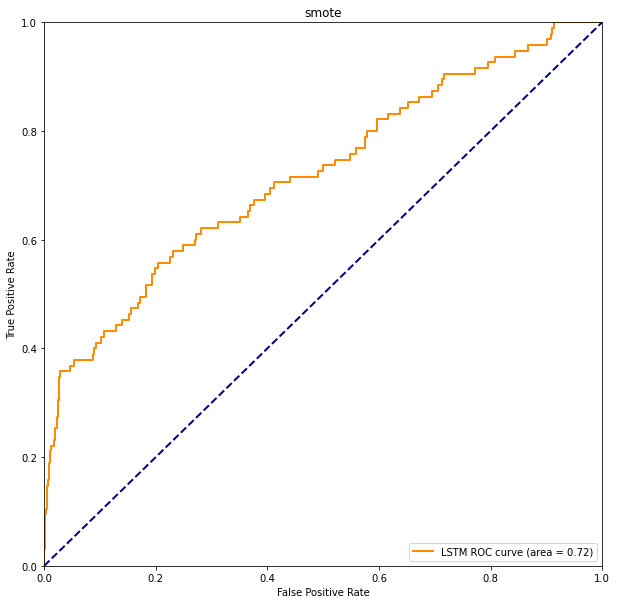

In [5]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_smote) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('smote')
plt.legend(loc="lower right")

plt.show()

In [6]:
y_pred_smote

array([[0.11835295],
       [0.10332951],
       [0.12534228],
       ...,
       [0.8252108 ],
       [0.10217404],
       [0.2875104 ]], dtype=float32)

In [7]:
print(x_train_lstm_nr.shape)
print(y_train_nr.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_nr.shape[0]           # number of training examples (2D)
#M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_nr = Sequential()

model_nr.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())

model_nr.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_nr.add(Dropout(dropout))
model_nr.add(BatchNormalization())


model_nr.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_nr.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_nr.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_nr.fit(x_train_lstm_nr, y_train_nr,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0.2,
                    #validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_nr.evaluate(x_train_lstm_nr, y_train_nr,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_nr.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

(760, 22, 6)
(760,)
layers=[8, 8, 8, 1], train_examples=760, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 22, 8)             480       
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 22, 8)             32        
_________________________________________________________________
lstm_5 (LSTM)                (None, 22, 8)             544       
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 8)             0         
___________________________________________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 1s - loss: 0.7553 - accuracy: 0.5707 - f1_m: 0.4615 - precision_m: 0.4339 - val_loss: 0.8109 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
Epoch 3/3
 - 1s - loss: 0.7662 - accuracy: 0.5395 - f1_m: 0.3634 - precision_m: 0.3852 - val_loss: 0.8332 - val_accuracy: 0.0000e+00 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00
-----------------------------------------------------------------
Training was completed in 51.36 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 50.0%
test accuracy = 98.2355%
test error = 95 out of 5384 examples


In [8]:
y_pred_nr= model_nr.predict(x_test_lstm)

predict_test_nr=[]
for i in range(y_pred_nr.shape[0]): 
    if y_pred_nr[i]>0.5:
        predict_test_nr.append(1)
    else:
        predict_test_nr.append(0)
predict_test_nr = np.array(predict_test_nr)
print(predict_test_nr)

[0 0 0 ... 0 0 0]


In [9]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_nr,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_nr)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

nr_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, nr_roc_auc = roc_curve_and_score(y_test, y_pred_nr)
nr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
nr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('nr_accuracy: %0.2f' %nr_accuracy)
print('nr_auc: %0.2f' %nr_roc_auc)
print('nr_sensitivity: %0.2f' %nr_sensitivity)
print('nr_specificity: %0.2f' %nr_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[5289    0]
 [  95    0]]
nr_accuracy: 0.98
nr_auc: 0.51
nr_sensitivity: 0.00
nr_specificity: 1.00
ppv: nan
npv: 0.9823551263001485


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in longlong_scalars


<Figure size 432x288 with 0 Axes>

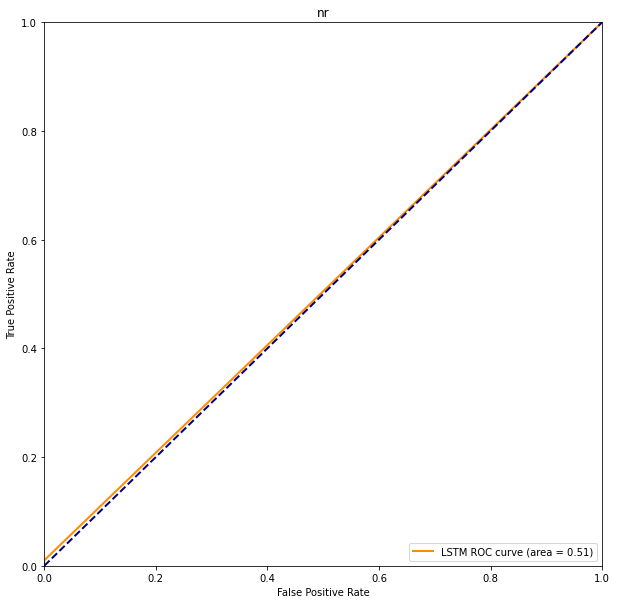

In [10]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred_nr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('nr')
plt.legend(loc="lower right")

plt.show()

In [11]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo1
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[part_0:], x_event_1[part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1]))

y_train_lstm_new=np.concatenate((y_event_0[part_0:], y_event_1[part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_1 = Sequential()

model_1.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())

model_1.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_1.add(Dropout(dropout))
model_1.add(BatchNormalization())


model_1.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_1.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_1.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_1.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_1.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_1.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred1= model_1.predict(x_test_lstm)
predict_train_lstm1=model_1.predict(x_train_lstm)

test_acc_1=test_acc
test_precision_1=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 22, 8)             480       
_________________________________________________________________
dropout_7 (Dropout)          (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 22, 8)             32        
_________________________________________________________________
lstm_8 (LSTM)                (None, 22, 8)             544       
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 84s - loss: 0.6143 - accuracy: 0.6819 - f1_m: 0.6075 - precision_m: 0.7917 - val_loss: 0.5772 - val_accuracy: 0.7051 - val_f1_m: 0.3350 - val_precision_m: 0.5019
Epoch 3/3
 - 88s - loss: 0.6034 - accuracy: 0.6878 - f1_m: 0.6150 - precision_m: 0.7960 - val_loss: 0.5813 - val_accuracy: 0.7010 - val_f1_m: 0.3160 - val_precision_m: 0.5019
-----------------------------------------------------------------
Training was completed in 258.16 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 69.5327%
test accuracy = 92.1805%
test error = 421 out of 5384 examples


In [12]:
predict_test_1=[]
for i in range(y_pred1.shape[0]): 
    if y_pred1[i]>0.5:
        predict_test_1.append(1)
    else:
        predict_test_1.append(0)
predict_test_1 = np.array(predict_test_1)
print(predict_test_1)

[0 0 0 ... 1 0 0]


In [13]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_1,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_1)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('sensitivity:',sensitivity)
print('specificity:',specificity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4928  361]
 [  60   35]]
sensitivity: 0.3684210526315789
specificity: 0.9317451314048024
ppv: 0.08838383838383838
npv: 0.9879711307137129


In [14]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo2
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:part_0], x_event_1[:part_1],x_event_0[2*part_0:],x_event_1[2*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[part_0:2*part_0], x_event_1[part_1:2*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:part_0], y_event_1[:part_1],y_event_0[2*part_0:], y_event_1[2*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[part_0:2*part_0], y_event_1[part_1:2*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_2 = Sequential()

model_2.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_2.add(Dropout(dropout))
model_2.add(BatchNormalization())


model_2.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_2.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_2.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_2.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_2.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_2.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred2= model_2.predict(x_test_lstm)
predict_train_lstm2=model_2.predict(x_train_lstm)

test_acc_2=test_acc
test_precision_2=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_10 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_11 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 78s - loss: 0.6133 - accuracy: 0.6795 - f1_m: 0.6319 - precision_m: 0.7435 - val_loss: 0.5828 - val_accuracy: 0.6967 - val_f1_m: 0.3929 - val_precision_m: 0.5012
Epoch 3/3
 - 60s - loss: 0.5931 - accuracy: 0.6876 - f1_m: 0.6422 - precision_m: 0.7546 - val_loss: 0.5543 - val_accuracy: 0.7012 - val_f1_m: 0.3516 - val_precision_m: 0.5013
-----------------------------------------------------------------
Training was completed in 260.31 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 70.8855%
test accuracy = 84.3239%
test error = 844 out of 5384 examples


In [15]:
predict_test_2=[]
for i in range(y_pred2.shape[0]): 
    if y_pred2[i]>0.5:
        predict_test_2.append(1)
    else:
        predict_test_2.append(0)
predict_test_2 = np.array(predict_test_2)
print(predict_test_2)

[0 0 0 ... 1 0 0]


In [16]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_2,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_2)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4495  794]
 [  50   45]]
specificity: 0.849877103422197
sensitivity: 0.47368421052631576
ppv: 0.05363528009535161
npv: 0.988998899889989


In [17]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo3
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:2*part_0], x_event_1[:2*part_1],x_event_0[3*part_0:],x_event_1[3*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[2*part_0:3*part_0], x_event_1[2*part_1:3*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:2*part_0], y_event_1[:2*part_1],y_event_0[3*part_0:], y_event_1[3*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[2*part_0:3*part_0], y_event_1[2*part_1:3*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_3 = Sequential()

model_3.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
             #  dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_3.add(Dropout(dropout))
model_3.add(BatchNormalization())


model_3.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_3.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_3.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_3.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_3.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_3.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred3= model_3.predict(x_test_lstm)
predict_train_lstm3=model_3.predict(x_train_lstm)

test_acc_3=test_acc
test_precision_3=test_precision

(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_13 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_14 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_14 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 63s - loss: 0.6614 - accuracy: 0.6430 - f1_m: 0.6162 - precision_m: 0.6630 - val_loss: 0.6288 - val_accuracy: 0.6765 - val_f1_m: 0.3720 - val_precision_m: 0.5016
Epoch 3/3
 - 79s - loss: 0.6233 - accuracy: 0.6841 - f1_m: 0.6391 - precision_m: 0.7394 - val_loss: 0.5954 - val_accuracy: 0.7033 - val_f1_m: 0.3599 - val_precision_m: 0.5015
-----------------------------------------------------------------
Training was completed in 296.03 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 70.475%
test accuracy = 82.9123%
test error = 920 out of 5384 examples


In [18]:
predict_test_3=[]
for i in range(y_pred3.shape[0]): 
    if y_pred3[i]>0.5:
        predict_test_3.append(1)
    else:
        predict_test_3.append(0)
predict_test_3 = np.array(predict_test_3)
print(predict_test_3)

[0 0 0 ... 1 0 0]


In [19]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_3,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_3)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4418  871]
 [  49   46]]
specificity: 0.835318585743997
sensitivity: 0.4842105263157895
ppv: 0.05016357688113413
npv: 0.9890306693530334


In [20]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo4
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:3*part_0], x_event_1[:3*part_1],x_event_0[4*part_0:],x_event_1[4*part_1:]))
x_valid_lstm_new=np.concatenate((x_event_0[3*part_0:4*part_0], x_event_1[3*part_1:4*part_1]))

y_train_lstm_new=np.concatenate((y_event_0[:3*part_0], y_event_1[:3*part_1],y_event_0[4*part_0:], y_event_1[4*part_1:]))
y_valid_lstm_new=np.concatenate((y_event_0[3*part_0:4*part_0], y_event_1[3*part_1:4*part_1]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)


LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_4 = Sequential()

model_4.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
              # dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_4.add(Dropout(dropout))
model_4.add(BatchNormalization())


model_4.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_4.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_4.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_4.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_4.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_4.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred4= model_4.predict(x_test_lstm)
predict_train_lstm4=model_4.predict(x_train_lstm)

test_acc_4=test_acc
test_precision_4=test_precision


(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_16 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_17 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 77s - loss: 0.6039 - accuracy: 0.6956 - f1_m: 0.6672 - precision_m: 0.7357 - val_loss: 0.5790 - val_accuracy: 0.7051 - val_f1_m: 0.3293 - val_precision_m: 0.5012
Epoch 3/3
 - 64s - loss: 0.5841 - accuracy: 0.7139 - f1_m: 0.6898 - precision_m: 0.7502 - val_loss: 0.5400 - val_accuracy: 0.7466 - val_f1_m: 0.4194 - val_precision_m: 0.5012
-----------------------------------------------------------------
Training was completed in 284.97 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 74.4211%
test accuracy = 75.5201%
test error = 1318 out of 5384 examples


In [21]:
predict_test_4=[]
for i in range(y_pred4.shape[0]): 
    if y_pred4[i]>0.5:
        predict_test_4.append(1)
    else:
        predict_test_4.append(0)
predict_test_4 = np.array(predict_test_4)
print(predict_test_4)

[0 0 0 ... 1 0 1]


In [22]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_4,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_4)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])   

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4015 1274]
 [  44   51]]
specificity: 0.7591227075061449
sensitivity: 0.5368421052631579
ppv: 0.038490566037735846
npv: 0.989159891598916


In [23]:
x_event_0=x_train_lstm[:train_control]   #切出正常組 事件組   #loo5
y_event_0=y_train[:train_control]

x_event_1=x_train_lstm[train_control:]
y_event_1=y_train[train_control:]

part_0=int(int(x_event_0.shape[0])/5)
part_1=int(int(x_event_1.shape[0])/5)

x_train_lstm_new=np.concatenate((x_event_0[:4*part_0], x_event_1[:4*part_1]))
x_valid_lstm_new=np.concatenate((x_event_0[4*part_0:], x_event_1[4*part_1:]))

y_train_lstm_new=np.concatenate((y_event_0[:4*part_0], y_event_1[:4*part_1]))
y_valid_lstm_new=np.concatenate((y_event_0[4*part_0:], y_event_1[4*part_1:]))

print(x_train_lstm_new.shape)
print(x_valid_lstm_new.shape)

print(y_train_lstm_new.shape)
print(y_valid_lstm_new.shape)

LAYERS = [8,8,8,1]                # number of units in hidden and output layers
M_TRAIN = x_train_lstm_new.shape[0]           # number of training examples (2D)
M_VALIDATION =x_valid_lstm_new.shape[0]  
M_TEST = x_test_lstm.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = x_train_lstm.shape[2]                 # number of features

#BATCH = M_TRAIN                          # batch size
DP = 1                            # dropout rate
RDP = 1                          # recurrent dropout rate
print(f'layers={LAYERS}, train_examples={M_TRAIN}, test_examples={M_TEST}')
print(f'batch = {BATCH}, timesteps = {T}, features = {N}, epochs = {EPOCH}')
print(f'lr = {LR}, lambda = {LAMBD}, dropout = {DP}, recurr_dropout = {RDP}')
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Build the Model
model_5 = Sequential()

model_5.add(LSTM(input_shape=(T, N), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
            #   dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
           #    dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))
model_5.add(Dropout(dropout))
model_5.add(BatchNormalization())


model_5.add(Dense(units=LAYERS[3], activation='sigmoid'))

# Compile the model with Adam optimizer
model_5.compile(loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m], optimizer=Adam(lr=LR))

print(model_5.summary())

# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation
start = time()

##################################################

History = model_5.fit(x_train_lstm_new, y_train_lstm_new,
                    epochs=EPOCH,
                    batch_size=BATCH,
                    validation_split=0,
                    validation_data=(x_valid_lstm_new[:M_VALIDATION], y_valid_lstm_new[:M_VALIDATION]),
                    #validation_data=(x_test_lstm[:M_TEST], y_test[:M_TEST]),
                    shuffle=True,
                    verbose=2,
                    callbacks=[lr_decay, early_stop])

print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)
# Evaluate the model:
train_loss, train_acc, train_f1_score, train_precision = model_5.evaluate(x_train_lstm_new, y_train_lstm_new,
                                       batch_size=BATCH, verbose=0)

test_loss, test_acc, test_f1_score, test_precision = model_5.evaluate(x_test_lstm[:M_TEST], y_test[:M_TEST],
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

y_pred5= model_5.predict(x_test_lstm)
predict_train_lstm5=model_5.predict(x_train_lstm)

test_acc_5=test_acc
test_precision_5=test_precision

(33856, 22, 6)
(8464, 22, 6)
(33856,)
(8464,)
layers=[8, 8, 8, 1], train_examples=33856, test_examples=5384
batch = 32, timesteps = 22, features = 6, epochs = 3
lr = 0.001, lambda = 0.001, dropout = 1, recurr_dropout = 1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 22, 8)             480       
_________________________________________________________________
dropout_19 (Dropout)         (None, 22, 8)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 22, 8)             32        
_________________________________________________________________
lstm_20 (LSTM)               (None, 22, 8)             544       
_________________________________________________________________
dropout_20 (Dropout)         (None, 22, 8)             0         
_______________________________

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,val_f1_m,val_precision_m,loss,accuracy,f1_m,precision_m,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 51s - loss: 0.6139 - accuracy: 0.6815 - f1_m: 0.6592 - precision_m: 0.7083 - val_loss: 0.5661 - val_accuracy: 0.7133 - val_f1_m: 0.4329 - val_precision_m: 0.5012
Epoch 3/3
 - 55s - loss: 0.5938 - accuracy: 0.6955 - f1_m: 0.6811 - precision_m: 0.7122 - val_loss: 0.5488 - val_accuracy: 0.7032 - val_f1_m: 0.3471 - val_precision_m: 0.5016
-----------------------------------------------------------------
Training was completed in 188.24 secs
-----------------------------------------------------------------
-----------------------------------------------------------------
train accuracy = 69.7424%
test accuracy = 84.3796%
test error = 841 out of 5384 examples


In [24]:
predict_test_5=[]
for i in range(y_pred5.shape[0]): 
    if y_pred5[i]>0.5:
        predict_test_5.append(1)
    else:
        predict_test_5.append(0)
predict_test_5 = np.array(predict_test_5)
print(predict_test_5)

[0 0 0 ... 1 0 0]


In [25]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test_5,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_5)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

print('specificity:',specificity)
print('sensitivity:',sensitivity)
print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[4502  787]
 [  54   41]]
specificity: 0.8512006050293061
sensitivity: 0.43157894736842106
ppv: 0.049516908212560384
npv: 0.9881474978050921


In [26]:
y_pred_temp=np.append(y_pred1,y_pred2)
y_pred_temp=np.append(y_pred_temp,y_pred3)
y_pred_temp=np.append(y_pred_temp,y_pred4)
y_pred_temp=np.append(y_pred_temp,y_pred5)

predict_train_temp=np.append(predict_train_lstm1,predict_train_lstm2)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm3)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm4)
predict_train_temp=np.append(predict_train_temp,predict_train_lstm5)

y_pred=np.array(y_pred_temp).reshape(x_test_lstm.shape[0],5, order='F') #轉維
predict_train_lstm=np.array(predict_train_temp).reshape(x_train_lstm.shape[0],5, order='F') #轉維

y_pred= np.mean(y_pred, axis=1)
predict_train_lstm= np.mean(predict_train_lstm, axis=1)
 

In [27]:
predict_test=[]
for i in range(y_pred.shape[0]): 
    if y_pred[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)
print(predict_test)

[0 0 0 ... 1 0 0]


In [28]:
y_test_1D=np.array(y_test).reshape(total_test)

#predict_train_lstm = model.predict(x_train_lstm)
#predict_train_lstm=np.array(predict_train_lstm).reshape(total_train.shape[0]) #37536

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

accuracy_5_fold=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

fpr, tpr, fold_roc_auc = roc_curve_and_score(y_test, y_pred)

specificity_5_fold = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity_5_fold = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1])  

print('5_fold_accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('5_fold_auc : %0.2f' %fold_roc_auc)  #accuracy
print('5_fold_sensitivity: %0.2f' %sensitivity_5_fold)
print('5_fold_specificity: %0.2f' %specificity_5_fold)

print('ppv:',ppv)
print('npv:',npv)


y_pred=np.array(y_pred).reshape(total_test)

flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if y_pred[i]>0.5:
            total_predict=total_predict+y_pred[i]
            flag=flag+1
            

Confusion Matrix : 
 [[4502  787]
 [  48   47]]
5_fold_accuracy : 0.84
5_fold_auc : 0.74
5_fold_sensitivity: 0.49
5_fold_specificity: 0.85
ppv: 0.05635491606714628
npv: 0.8512006050293061


<Figure size 432x288 with 0 Axes>

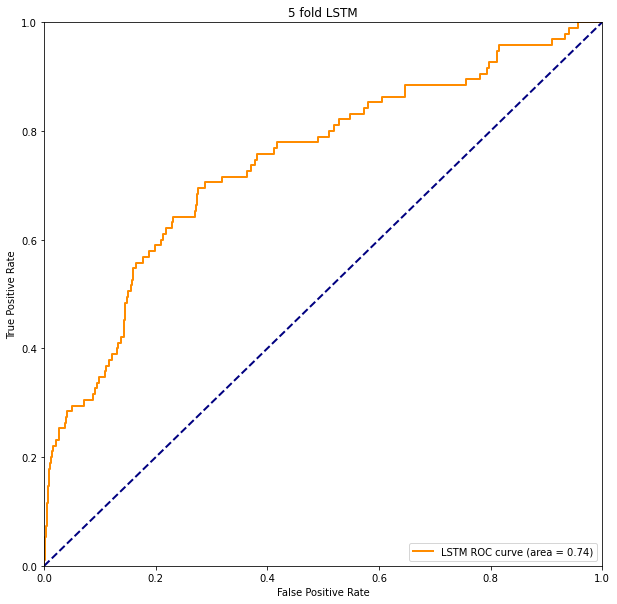

In [29]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('5 fold LSTM')
plt.legend(loc="lower right")

plt.show()

In [30]:
print('accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

accuracy : 0.84
AUC : 0.74
Sensitivity : 0.43
Specificity :0.85
64.81555057086533


In [31]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import model_selection

forest = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
 }

forest = model_selection.GridSearchCV(forest, rf_params, cv=5)
forest = forest.fit(x_train_base, y_train)

prob_predict_y_validation1 = forest.predict_proba(x_train_base)#给出带有概率值的结果，每个点所有label的概率和为1
prob_predict_y_validation = forest.predict_proba(x_test_base)#给出带有概率值的结果，每个点所有label的概率和为1


y_score = prob_predict_y_validation[:, 1]
# 預測
predict_train_rf = prob_predict_y_validation1[:, 1]

test_y_predicted = forest.predict(x_test_base)

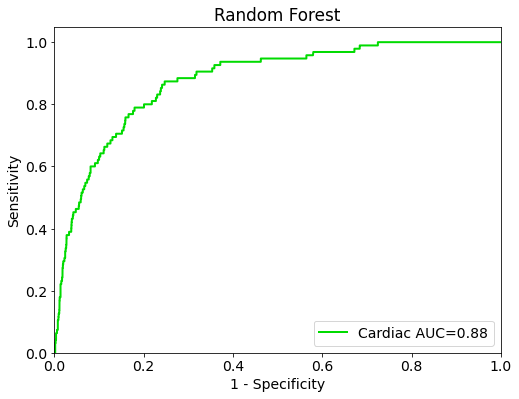

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Random Forest')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [33]:
predict_test=[]
for i in range(y_score.shape[0]): 
    if y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_test).reshape(total_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

Accuracy  = (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])   

specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('Accuracy : %0.2f' %Accuracy)  #Accuracy
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)



Confusion Matrix : 
 [[4967  322]
 [  46   49]]
Accuracy : 0.93
AUC : 0.88
Sensitivity : 0.52
Specificity :0.94


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg = LogisticRegression()
logreg.fit(x_train_base, y_train)

C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [35]:
predict_train_logistic_result = logreg.predict_proba(x_train_base)

predict_train_logistic = predict_train_logistic_result[:, 1]

logreg_test_y_predicted = logreg.predict_proba(x_test_base)

log_y_score = logreg_test_y_predicted[:, 1]

predict_test=[]
for i in range(log_y_score.shape[0]): 
    if log_y_score[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix

cm1 = confusion_matrix(y_test,predict_test)

sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))
print('Accuracy: %f' % accuracy_score(y_test, predict_test))
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)

pd.crosstab(y_test_log,predict_test,rownames=['label'],colnames=['predict'])

Accuracy: 0.799777
Sensitivity : 0.79
Specificity :0.80


predict,0,1
label,,
0,4231,1058
1,20,75


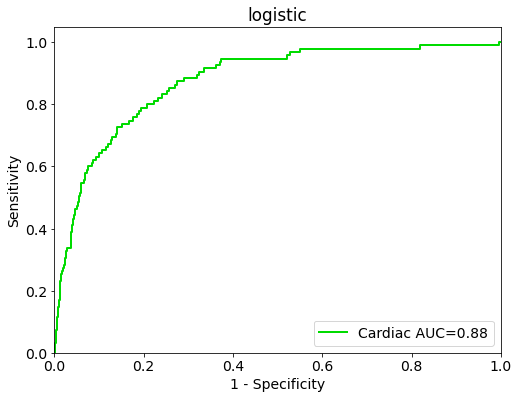

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
#plt.grid()
fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_y_score)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('logistic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()

In [37]:
print(predict_train_logistic)
print(predict_train_lstm)

stacking=np.append(predict_train_logistic, predict_train_lstm)
x_train_stacking=np.array(stacking).reshape(x_train_lstm.shape[0],2, order='F') #轉維

from sklearn import  svm, preprocessing, metrics 
from sklearn.svm import SVC
from sklearn import svm
from sklearn.preprocessing import StandardScaler

svm_stacking = svm.SVC(kernel='linear',probability=True)
svm_stacking.fit(x_train_stacking,y_train)

print(x_train_stacking.shape)
print(y_train.shape)

print(log_y_score.shape)#logistic test 機率
print(y_pred.shape)#lstm test 機率 
print(y_score.shape)#Rf test 機率

stacking_test=np.append(y_pred, log_y_score)
x_test_stacking=np.array(stacking_test).reshape(total_test,2, order='F') #轉維


[0.14063802 0.03412005 0.47621695 ... 0.64044788 0.85612376 0.2473725 ]
[0.30127573 0.3019746  0.4245561  ... 0.4680894  0.76894474 0.5381863 ]
(42320, 2)
(42320,)
(5384,)
(5384,)
(5384,)


In [38]:
predict=svm_stacking.predict(x_test_stacking)
predict_pro_stacking=svm_stacking.predict_proba(x_test_stacking)

accuracy = metrics.accuracy_score(y_test, predict)
precision  = metrics.precision_score(y_test, predict)

print(accuracy)
print(precision)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_stacking=predict_pro_stacking[:,1:2]

#################92個test ca 輸出#####################
#test=pd.DataFrame(predict[4689:])
#test.to_csv('24hour_ca.csv', index=False)
####################################### predict_pro_stacking

0.8189078751857355
0.07528957528957529


In [39]:
predict_test_stacking=[]
for i in range(predict_pro_stacking.shape[0]): 
    if predict_pro_stacking[i]>0.5:
        predict_test_stacking.append(1)
    else:
        predict_test_stacking.append(0)
predict_test_stacking = np.array(predict_test_stacking)


In [40]:
#pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  

y_test_1D=np.array(y_test).reshape(total_test)

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_stacking)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

fpr, tpr, stacking_svm_roc_auc = roc_curve_and_score(y_test, predict_pro_stacking)

stacking_svm_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[0,1]) 


print('stacking_svm_Accuracy: %0.2f' %stacking_svm_accuracy)
print('stacking_svm_auc: %0.2f' %stacking_svm_roc_auc)
print('stacking_svm_sensitivity: %0.2f' %stacking_svm_sensitivity)
print('stacking_svm_specificity: %0.2f' %stacking_svm_specificity)

print('ppv:',ppv)
print('npv:',npv)
flag=0
total_predict=0
for i in range(y_pred.shape[0]): 
      if predict_pro_stacking[i]>0.5:
            total_predict=total_predict+predict_pro_stacking[i]
            flag=flag+1
#print(flag)  #score

#print(y_test_1D)

Confusion Matrix : 
 [[4395  894]
 [  18   77]]
stacking_svm_Accuracy: 0.83
stacking_svm_auc: 0.89
stacking_svm_sensitivity: 0.81
stacking_svm_specificity: 0.83
ppv: 0.07929969104016478
npv: 0.8309699376063528


<Figure size 432x288 with 0 Axes>

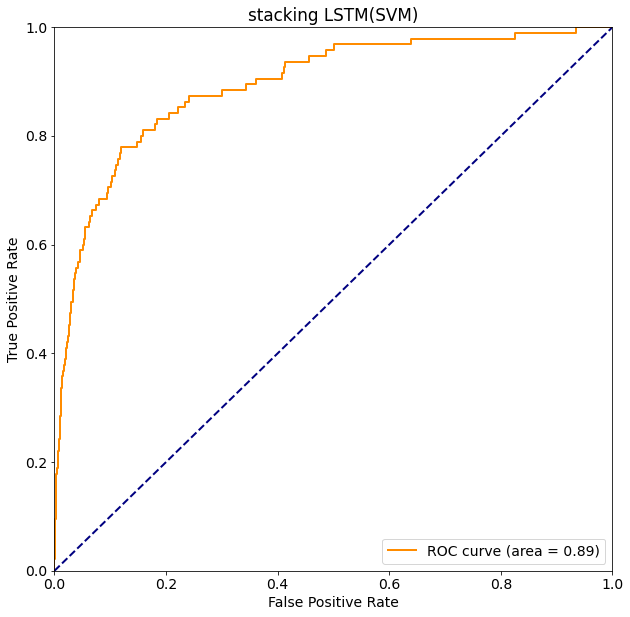

In [41]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, predict_pro_stacking) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('stacking LSTM(SVM)')
plt.legend(loc="lower right")

plt.show()

In [42]:
print('Accuracy : %0.2f' %accuracy)  #Accuracy
print('precision : %0.2f' %precision)  #precision
print('AUC : %0.2f' % roc_auc)  #AUC
print('Sensitivity : %0.2f' % sensitivity )
print('Specificity :%0.2f' % specificity)
#print('f1_score :%0.2f' %test_f1_score)  #f1_score
print(total_predict/flag*100)  #score

Accuracy : 0.82
precision : 0.08
AUC : 0.89
Sensitivity : 0.79
Specificity :0.80
[74.77865612]


In [43]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn import model_selection

gbm = xgb.XGBRegressor()

xgb_params = {
'learning_rate': [0.1,0.2,0.5],
'n_estimators': [30,50,100],
'max_depth': [5,10,20],
 'alpha': [0.4,0.6],
 }

xg_reg = model_selection.GridSearchCV(gbm, xgb_params, cv=5)
xg_reg.fit(x_train_stacking,y_train)

y_pred_xgb = xg_reg.predict(x_test_stacking)


In [44]:
predict_test_xgb=[]
for i in range(y_pred_xgb.shape[0]): 
    if y_pred_xgb[i]>0.5:
        predict_test_xgb.append(1)
    else:
        predict_test_xgb.append(0)
predict_test_xgb = np.array(predict_test_xgb)

pd.crosstab(y_test_1D,predict_test_xgb,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_xgb)

fpr, tpr, stacking_xg_roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

stacking_xg_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_xg_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_xg_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


print('stacking_xg_accuracy : %0.2f' % stacking_xg_accuracy )
print('stacking_xg_auc : %0.2f' % stacking_xg_roc_auc )
print('stacking_xg_Sensitivity : %0.2f' % stacking_xg_sensitivity )
print('stacking_xg_Specificity :%0.2f' % stacking_xg_specificity)

accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])
print('accuracy :%0.2f' % accuracy)


Confusion Matrix : 
 [[4440  849]
 [  19   76]]
stacking_xg_accuracy : 0.84
stacking_xg_auc : 0.90
stacking_xg_Sensitivity : 0.80
stacking_xg_Specificity :0.84
accuracy :0.84


In [45]:
from sklearn.model_selection import train_test_split
from sklearn import metrics,ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

forest_stacking = ensemble.RandomForestClassifier()

rf_params = {
'n_estimators': [15,20,25],
'max_depth': [4,5,6,7]
#'n_estimators': [5],
#'max_depth': [5]
 }

forest_stacking = model_selection.GridSearchCV(forest_stacking, rf_params, cv=5)
forest_fit=forest_stacking.fit(x_train_stacking,y_train)

prob_predict_y_validation_stacking = forest_stacking.predict_proba(x_test_stacking)#给出带有概率值的结果，每个点所有label的概率和为1
y_score_stacking = prob_predict_y_validation_stacking[:, 1]


In [46]:
predict_test=[]
for i in range(y_score_stacking.shape[0]): 
    if y_score_stacking[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
stacking_rf_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
stacking_rf_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

fpr,tpr,stacking_rf_roc_auc = roc_curve_and_score(y_test, y_score_stacking) ###計算真正率和假正率

stacking_rf_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,0]+cm1[1,1])

print('stacking_rf_accuracy :%0.2f' % stacking_rf_accuracy)
print('stacking_rf_roc_auc : %0.2f' % stacking_rf_roc_auc)  #AUC
print('stacking_rf_sensitivity : %0.2f' % stacking_rf_sensitivity )
print('stacking_rf_Specificity :%0.2f' % stacking_rf_specificity)

print(forest_stacking.best_params_)
print(forest_stacking.best_score_)

Confusion Matrix : 
 [[4489  800]
 [  18   77]]
stacking_rf_accuracy :0.85
stacking_rf_roc_auc : 0.89
stacking_rf_sensitivity : 0.81
stacking_rf_Specificity :0.85
{'max_depth': 6, 'n_estimators': 20}
0.8431001890359168


In [47]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train_stacking, y_train)

KNeighborsClassifier(n_neighbors=2)

In [48]:
nei_test_y_predicted = neigh.predict(x_test_stacking)
predict_test=[]
for i in range(nei_test_y_predicted.shape[0]): 
    if nei_test_y_predicted[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

#print(predict_test)

from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score,confusion_matrix
fpr, tpr, stacking_nei_roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)

cm1 = confusion_matrix(y_test_1D,predict_test)

stacking_nei_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])
stacking_nei_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
stacking_nei_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))

print('stacking_nei_accuracy : %0.2f' % stacking_nei_accuracy )
print('stacking_nei_roc_auc : %0.2f' % stacking_nei_roc_auc )

print('stacking_nei_Sensitivity : %0.2f' % stacking_nei_sensitivity )
print('stacking_nei_Specificity :%0.2f' % stacking_nei_specificity)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])


stacking_nei_accuracy : 0.88
stacking_nei_roc_auc : 0.77
stacking_nei_Sensitivity : 0.66
stacking_nei_Specificity :0.88


predict,0,1
label,,
0,4668,621
1,32,63


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import f_regression

logreg_stacking = LogisticRegression()
logreg_stacking.fit(x_train_stacking, y_train)
#log_test_y_predicted = logreg.fit(x_train_stacking, y_train).decision_function(X_test)

LogisticRegression()

In [50]:
logreg_test_y_predicted_pro = logreg_stacking.predict_proba(x_test_stacking)

log_score = logreg_test_y_predicted_pro[:, 1]

predict_test_lr=[]
for i in range(log_score.shape[0]): 
    if log_score[i]>0.5:
        predict_test_lr.append(1)
    else:
        predict_test_lr.append(0)
predict_test_lr = np.array(predict_test_lr)

#print(predict_test)

fpr, tpr, stacking_lr_roc_auc = roc_curve_and_score(y_test, log_score)

cm1 = confusion_matrix(y_test_1D,predict_test_lr)

stacking_lr_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])

stacking_lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
stacking_lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

#print('Precision:',precision_score(y_test_1, predict_test))
#print('Recall:', recall_score(y_test_1, predict_test))
#print('f1-score: %f' % f1_score(y_test_1, predict_test))

print('stacking_lr_accuracy : %0.2f' % stacking_lr_accuracy )
print('stacking_lr_roc_auc : %0.2f' % stacking_lr_roc_auc )

print('stacking_lr_sensitivity : %0.2f' % stacking_lr_sensitivity )
print('stacking_lr_specificity :%0.2f' % stacking_lr_specificity)


pd.crosstab(y_test_1D,predict_test_lr,rownames=['label'],colnames=['predict'])

stacking_lr_accuracy : 0.82
stacking_lr_roc_auc : 0.89
stacking_lr_sensitivity : 0.82
stacking_lr_specificity :0.82


predict,0,1
label,,
0,4347,942
1,17,78


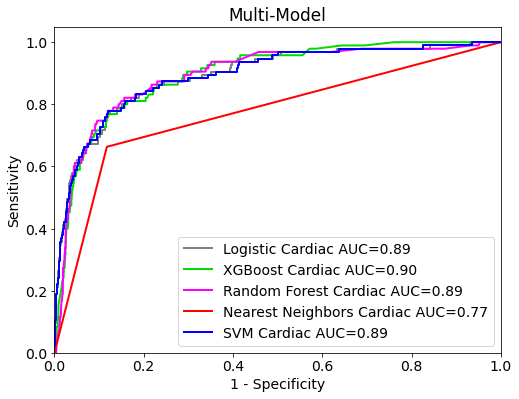

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc  ###計算roc和auc
from sklearn.model_selection import train_test_split

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})

#plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, log_score)
plt.plot(fpr, tpr, color='gray', lw=2,
         label='Logistic Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
plt.plot(fpr, tpr, color='#00db00', lw=2,
         label='XGBoost Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_score_stacking)
plt.plot(fpr, tpr, color='#ff00ff', lw=2,
         label='Random Forest Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, nei_test_y_predicted)
plt.plot(fpr, tpr, color='red', lw=2,
         label='Nearest Neighbors Cardiac AUC={0:.2f}'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, predict_pro_stacking)
plt.plot(fpr, tpr, color='blue', lw=2,
         label='SVM Cardiac AUC={0:.2f}'.format(roc_auc))

plt.title('Multi-Model')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')

plt.show()

In [52]:
y_score_stacking

array([0.47213752, 0.40719983, 0.14497031, ..., 0.96243467, 0.96549416,
       0.91154685])

In [53]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine=[]

#print(predict_pro_stacking)
#print(predict_pro_stacking.size)


for idx, i in enumerate(predict_pro_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine.append(predict_pro_stacking[idx])
    else:
        y_predict_combine.append((predict_pro_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine=np.array(y_predict_combine)
print(y_predict_combine.size)

5384


In [54]:
predict_test_combine=[]
for i in range(y_predict_combine.shape[0]): 
    if y_predict_combine[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

svm_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, svm_roc_auc = roc_curve_and_score(y_test, y_predict_combine)

svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('svm_accuracy_cxr : %0.2f' % svm_accuracy)
print('svm_auc_cxr : %0.2f' % svm_roc_auc )
print('svm_Sensitivity_cxr : %0.2f' % svm_sensitivity )
print('svm_Specificity_cxr :%0.2f' % svm_specificity)


Confusion Matrix : 
 [[4420  869]
 [  15   80]]
svm_accuracy_cxr : 0.84
svm_auc_cxr : 0.89
svm_Sensitivity_cxr : 0.84
svm_Specificity_cxr :0.84


<Figure size 432x288 with 0 Axes>

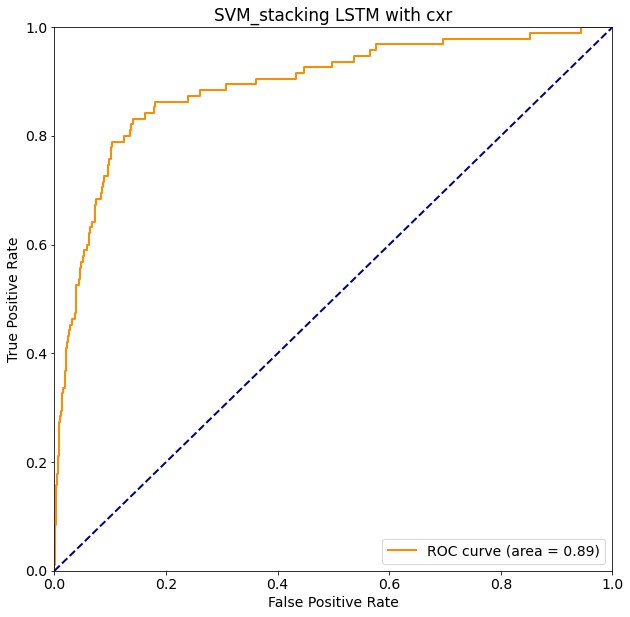

In [55]:
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [56]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_lr=[]

for idx, i in enumerate(log_score):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_lr.append(log_score[idx])
    else:
        y_predict_combine_lr.append((log_score[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_lr=np.array(y_predict_combine_lr)
print(y_predict_combine_lr.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [57]:
predict_test_combine=[]
for i in range(y_predict_combine_lr.shape[0]): 
    if y_predict_combine_lr[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

lr_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, lr_roc_auc = roc_curve_and_score(y_test, y_predict_combine_lr)

lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('lr_accuracy_cxr : %0.2f' % lr_accuracy)
print('lr_auc_cxr : %0.2f' % lr_roc_auc )
print('lr_Sensitivity_cxr : %0.2f' % lr_sensitivity )
print('lr_Specificity_cxr :%0.2f' % lr_specificity)

Confusion Matrix : 
 [[4378  911]
 [  14   81]]
lr_accuracy_cxr : 0.83
lr_auc_cxr : 0.89
lr_Sensitivity_cxr : 0.85
lr_Specificity_cxr :0.83


<Figure size 432x288 with 0 Axes>

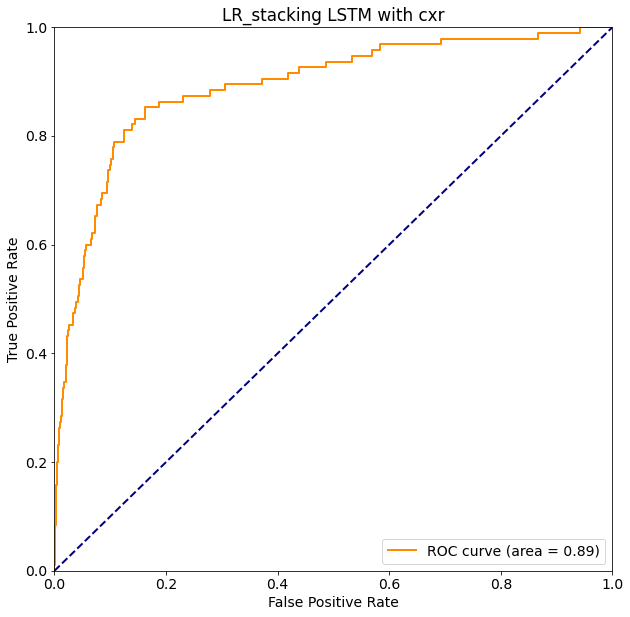

In [58]:
#predict_combine=pd.read_csv("predict_combine.csv")
#y_predict_combine=predict_combine[['eventV3']].values  
#print(y_predict_combine.shape)
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_test, y_predict_combine_lr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LR_stacking LSTM with cxr')
plt.legend(loc="lower right")

plt.show()

In [59]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_xg=[]

for idx, i in enumerate(y_pred_xgb):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_xg.append(y_pred_xgb[idx])
    else:
        y_predict_combine_xg.append((y_pred_xgb[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_xg=np.array(y_predict_combine_xg)
print(y_predict_combine_xg.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [60]:
predict_test_combine=[]
for i in range(y_predict_combine_xg.shape[0]): 
    if y_predict_combine_xg[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

xg_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, xg_roc_auc = roc_curve_and_score(y_test, y_predict_combine_xg)

xg_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
xg_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('xg_accuracy_cxr : %0.2f' % xg_accuracy)
print('xg_auc_cxr : %0.2f' % xg_roc_auc )
print('xg_Sensitivity_cxr : %0.2f' % xg_sensitivity )
print('xg_Specificity_cxr :%0.2f' % xg_specificity)

Confusion Matrix : 
 [[4466  823]
 [  17   78]]
xg_accuracy_cxr : 0.84
xg_auc_cxr : 0.89
xg_Sensitivity_cxr : 0.82
xg_Specificity_cxr :0.84


In [61]:
predict_cxr=pd.read_csv("neur_test_all_patients_ca1.csv")
y_predict_cxr=predict_cxr[['predict']].values

y_predict_combine_rf=[]

for idx, i in enumerate(y_score_stacking):
    if y_predict_cxr[idx]==-1:          
        y_predict_combine_rf.append(y_score_stacking[idx])
    else:
        y_predict_combine_rf.append((y_score_stacking[idx]+y_predict_cxr[idx])/2)
        
y_test_1D=np.array(y_test).reshape(total_test)
y_predict_combine_rf=np.array(y_predict_combine_rf)
print(y_predict_combine_rf.size)

5384


C:\Users\Tony\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


In [62]:
predict_test_combine=[]
for i in range(y_predict_combine_rf.shape[0]): 
    if y_predict_combine_rf[i]>0.5:
        predict_test_combine.append(1)
    else:
        predict_test_combine.append(0)
predict_test_combine = np.array(predict_test_combine)

pd.crosstab(y_test_1D,predict_test_combine,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test_combine)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

rf_accuracy=(cm1[0,0]+cm1[1,1])/(cm1[1,1]+cm1[0,0]+cm1[0,1]+cm1[1,0])


fpr, tpr, rf_roc_auc = roc_curve_and_score(y_test, y_predict_combine_rf)

rf_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
rf_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR

print('rf_accuracy_cxr : %0.2f' % rf_accuracy)
print('rf_auc_cxr : %0.2f' % rf_roc_auc )
print('rf_Sensitivity_cxr : %0.2f' % rf_sensitivity )
print('rf_Specificity_cxr :%0.2f' % rf_specificity)

Confusion Matrix : 
 [[4472  817]
 [  16   79]]
rf_accuracy_cxr : 0.85
rf_auc_cxr : 0.89
rf_Sensitivity_cxr : 0.83
rf_Specificity_cxr :0.85


0.12133271335541702


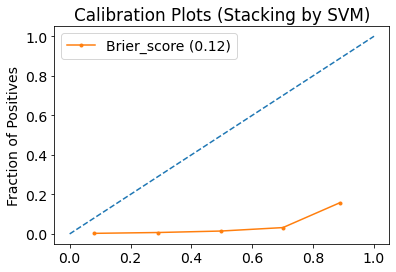

In [63]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, predict_pro_stacking)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, predict_pro_stacking)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by SVM)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

0.12523695148955144


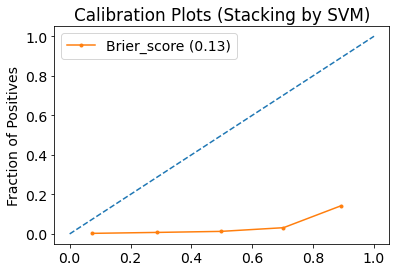

In [64]:
from sklearn.metrics import brier_score_loss
brier_score=brier_score_loss(y_test, log_score)
print(brier_score)

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

fop, mpv = calibration_curve(y_test, log_score)
#plt.figure()
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plots (Stacking by SVM)')
plt.plot(mpv, fop, marker='.', label='Brier_score (%1.2f)' % brier_score)
plt.legend(loc="upper left")
plt.show()

In [65]:
df_eicu=pd.read_csv("baseline_eicu_version2.csv")  #baseline 

y_validation=df_eicu['user']

x_lstm_validation=eicu_cardiac_total[['vHR','vRR','vsbp','vdbp','vmbp','vspo2']].values 

#x_lstm_validation=minmax_scale.fit_transform(x_lstm_validation)  #規一化
x_lstm_validation=np.array(x_lstm_validation).reshape(total_eicu,T,var) #轉三維  total 
#x_lstm_validation=np.array(x_lstm_validation).reshape(10665,T,var) #轉三維  total 

print(x_lstm_validation.shape)
print(y_validation.shape)

(10049, 22, 6)
(10049,)


-----------------------------------------------------------------
test accuracy = 89.0238%
test error = 1103 out of 10049 examples


<Figure size 432x288 with 0 Axes>

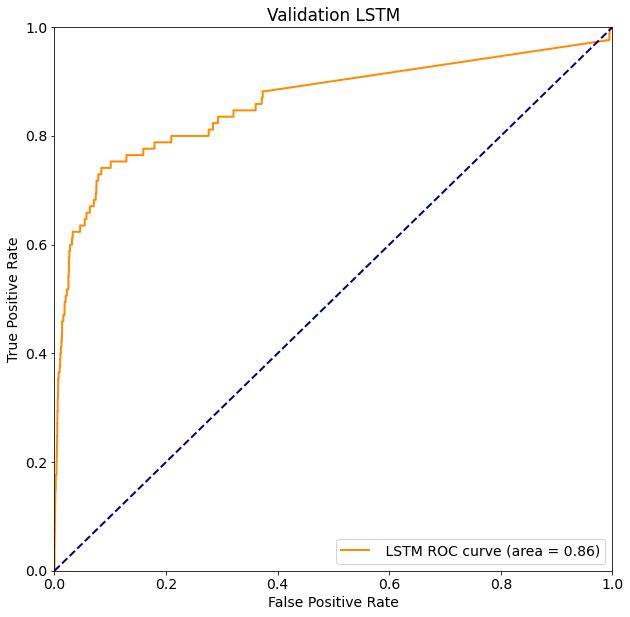

In [66]:
test_loss_1 ,test_acc_1, test_f1_score_1, test_precision_1 = model_1.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_1 * 100, 4)}%')
#print(f'test error = {round((1 - test_acc_1) * 10665)} out of {10665} examples')
print(f'test error = {round((1 - test_acc_1) * total_eicu)} out of {total_eicu} examples')

validation_pred1= model_1.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred1) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

-----------------------------------------------------------------
test accuracy = 75.8384%
test error = 2428 out of 10049 examples


<Figure size 432x288 with 0 Axes>

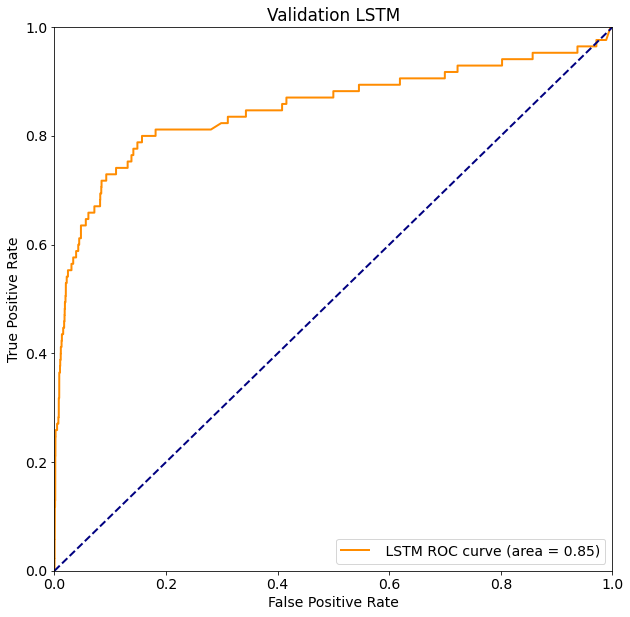

In [67]:
test_loss_2 ,test_acc_2, test_f1_score_2, test_precision_2 = model_2.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_2 * 100, 4)}%')
#print(f'test error = {round((1 - test_acc_2) * 10665)} out of {10665} examples')
print(f'test error = {round((1 - test_acc_2) * total_eicu)} out of {total_eicu} examples')

validation_pred2= model_2.predict(x_lstm_validation)


# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred2) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 79.8885%
test error = 2021 out of 10049 examples


<Figure size 432x288 with 0 Axes>

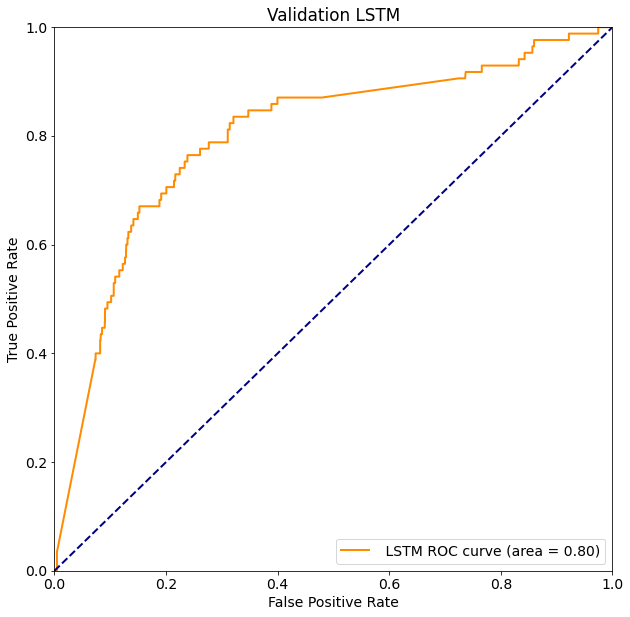

In [68]:
test_loss_3 ,test_acc_3, test_f1_score_3, test_precision_3 = model_3.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_3 * 100, 4)}%')
#print(f'test error = {round((1 - test_acc_3) * 10665)} out of {10665} examples')
print(f'test error = {round((1 - test_acc_3) * total_eicu)} out of {total_eicu} examples')

validation_pred3= model_3.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred3) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 61.5285%
test error = 3866 out of 10049 examples


<Figure size 432x288 with 0 Axes>

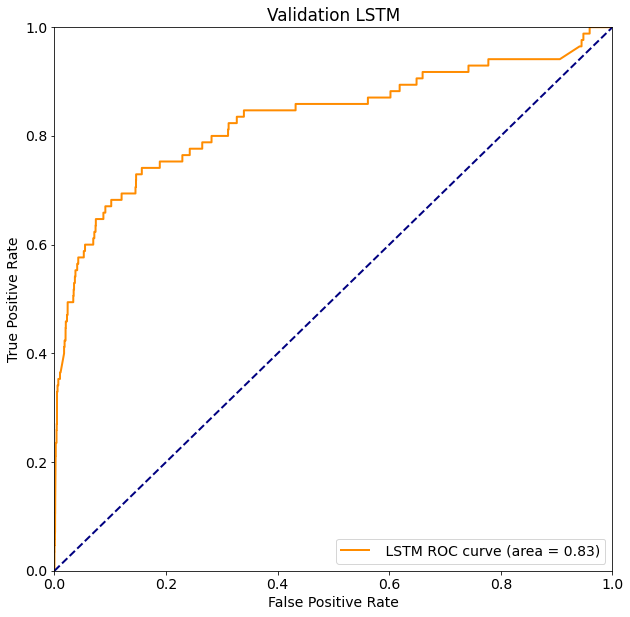

In [69]:
test_loss_4 ,test_acc_4, test_f1_score_4, test_precision_4 = model_4.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_4 * 100, 4)}%')
#print(f'test error = {round((1 - test_acc_4) * 10665)} out of {10665} examples')
print(f'test error = {round((1 - test_acc_4) * total_eicu)} out of {total_eicu} examples')

validation_pred4= model_4.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred4) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()


-----------------------------------------------------------------
test accuracy = 81.8589%
test error = 1823 out of 10049 examples


<Figure size 432x288 with 0 Axes>

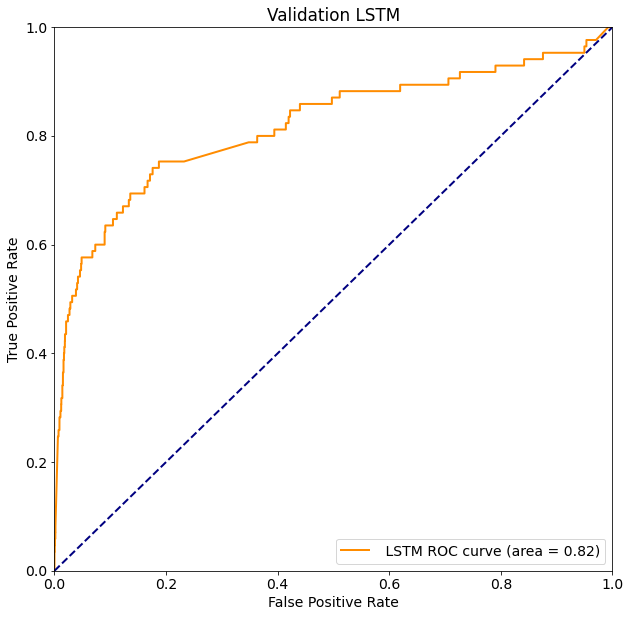

In [70]:
test_loss_5 ,test_acc_5, test_f1_score_5, test_precision_5 = model_5.evaluate(x_lstm_validation,y_validation,
                                     batch_size=BATCH, verbose=0)
print('-'*65)
print(f'test accuracy = {round(test_acc_5 * 100, 4)}%')
print(f'test error = {round((1 - test_acc_5) * total_eicu)} out of {total_eicu} examples')
#print(f'test error = {round((1 - test_acc_5) * 10665)} out of {10665} examples')

validation_pred5= model_5.predict(x_lstm_validation)

# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred5) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [71]:
pred_temp=np.append(validation_pred1,validation_pred2)
pred_temp=np.append(pred_temp,validation_pred3)
pred_temp=np.append(pred_temp,validation_pred4)
pred_temp=np.append(pred_temp,validation_pred5)

#validation_pred_old=np.array(pred_temp).reshape(10668,5, order='F') #轉維
validation_pred_old=np.array(pred_temp).reshape(total_eicu,5, order='F') #轉維

validation_pred_old= np.mean(validation_pred_old, axis=1)
 
eicu_acc=(test_acc_1+test_acc_2+test_acc_3+test_acc_4+test_acc_5)/5
eicu_precision=(test_precision_1+test_precision_2+test_precision_3+test_precision_4+test_precision_5)/5

<Figure size 432x288 with 0 Axes>

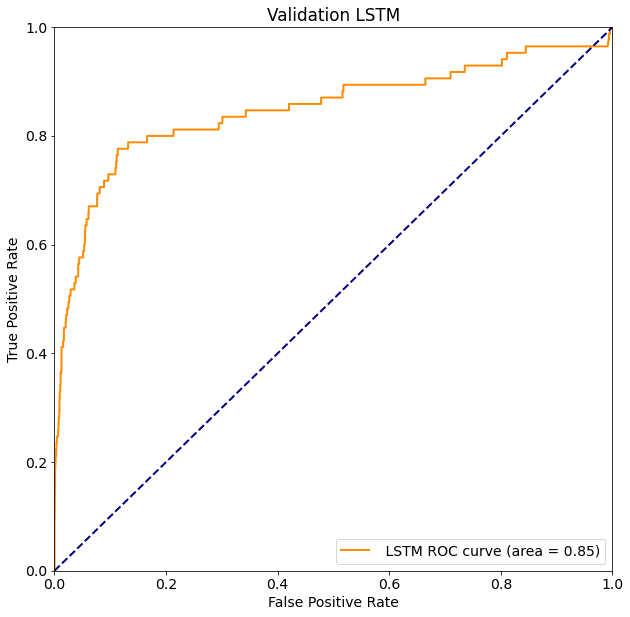

In [72]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation, validation_pred_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label=' LSTM ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation LSTM')
plt.legend(loc="lower right")

plt.show()

In [73]:
#y_validation_1D=np.array(y_validation).reshape(10665)
y_validation_1D=np.array(y_validation).reshape(total_eicu)

predict_test=[]
for i in range(validation_pred_old.shape[0]): 
    if validation_pred_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

pd.crosstab(y_validation_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_validation_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[7875 2089]
 [  17   68]]


In [74]:
#df_eicu=pd.read_csv("cascontrol_f2.csv")  #baseline  baseline_eicu_version2   cascontrol_f2
df_eicu=pd.read_csv("baseline_eicu_version2.csv")  #baseline  baseline_eicu_version2   cascontrol_f2

df_eicu=df_eicu.drop(['patientunitstayid'],axis=1)
df_eicu=df_eicu.drop(['patienthealthsystemstayid'],axis=1)
df_eicu=df_eicu.drop(['uniquepid'],axis=1)
df_eicu=df_eicu.drop(['CA'],axis=1)
df_eicu=df_eicu.drop(['hDied'],axis=1)

df_eicu=df_eicu.drop(['BMI'],axis=1)
df_eicu=df_eicu.drop(['ccscore'],axis=1)

#df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity","BMI"])
df_eicu=pd.get_dummies(data=df_eicu,columns=["first_careunit","ethnicity"])

y_validation_old=df_eicu['user']
df_eicu=df_eicu.drop(['user'],axis=1)
x_validation_old=df_eicu.values

minmax_scale =preprocessing.MinMaxScaler(feature_range=(0,1))

x_validation_old=minmax_scale.fit_transform(x_validation_old)

#predict_validation = forest.predict_proba(x_validation)#给出带有概率值的结果，每个点所有label的概率和为1
#y_score_validation_old = predict_validation[:, 1] #RF

predict_validation_old = logreg.predict_proba(x_validation_old)
y_score_validation_old = predict_validation_old[:, 1]

predict_test=[]
for i in range(y_score_validation_old.shape[0]): 
    if y_score_validation_old[i]>0.5:
        predict_test.append(1)
    else:
        predict_test.append(0)
predict_test = np.array(predict_test)

y_test_1D=np.array(y_validation_old).reshape(total_eicu)
#y_test_1D=np.array(y_validation_old).reshape(10665)

pd.crosstab(y_test_1D,predict_test,rownames=['label'],colnames=['predict'])  
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_test)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 
specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR
sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR


Confusion Matrix : 
 [[8244 1720]
 [  49   36]]


In [75]:
stacking_validation_test=np.append(validation_pred_old, y_score_validation_old)
#x_validation_stacking=np.array(stacking_validation_test).reshape(10665,2, order='F') #轉維
x_validation_stacking=np.array(stacking_validation_test).reshape(total_eicu,2, order='F') #轉維

predict=svm_stacking.predict(x_validation_stacking)
predict_pro_old=svm_stacking.predict_proba(x_validation_stacking)

accuracy = metrics.accuracy_score(y_validation_old, predict)
precision  = metrics.precision_score(y_validation_old, predict)

pd.crosstab(y_test_1D,predict,rownames=['label'],colnames=['predict'])
predict_pro_old=predict_pro_old[:,1:2]

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict)
print('Confusion Matrix : \n', cm1)
#####from confusion matrix calculate 

valid_svm_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

fpr, tpr, valid_svm_roc_auc = roc_curve_and_score(y_validation_old, predict_pro_old)

valid_svm_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
valid_svm_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  


print('valid_svm_accuracy: %0.2f' %valid_svm_accuracy)
print('valid_svm_roc_auc: %0.2f' %valid_svm_roc_auc)
print('valid_svm_sensitivity: %0.2f' %valid_svm_sensitivity)
print('valid_svm_specificity: %0.2f' %valid_svm_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[7975 1989]
 [  24   61]]
valid_svm_accuracy: 0.80
valid_svm_roc_auc: 0.83
valid_svm_sensitivity: 0.72
valid_svm_specificity: 0.80
ppv: 0.02975609756097561
npv: 0.9969996249531191


<Figure size 432x288 with 0 Axes>

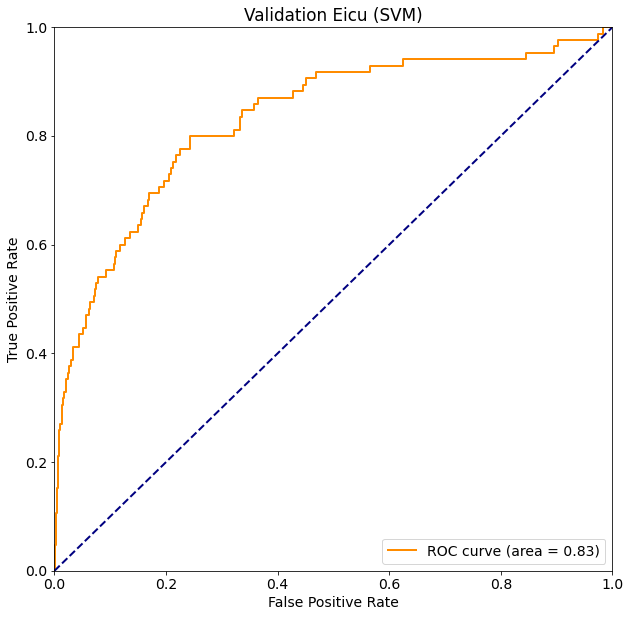

In [76]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation_old, predict_pro_old) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Eicu (SVM)')
plt.legend(loc="lower right")

plt.show()

predict_pro_old =pd.DataFrame(predict_pro_old)
#predict_pro_old.to_csv('predict.csv', index=False)

In [77]:
predict_lr=logreg_stacking.predict(x_validation_stacking)
predict_pro_old_lr=logreg_stacking.predict_proba(x_validation_stacking)

accuracy = metrics.accuracy_score(y_validation_old, predict_lr)
precision  = metrics.precision_score(y_validation_old, predict_lr)

pd.crosstab(y_test_1D,predict_lr,rownames=['label'],colnames=['predict'])
predict_pro_old_lr=predict_pro_old_lr[:,1:2]

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test_1D,predict_lr)
print('Confusion Matrix : \n', cm1)

#####from confusion matrix calculate


fpr, tpr, valid_lr_roc_auc = roc_curve_and_score(y_validation_old, predict_pro_old_lr)

valid_lr_sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])   #TPR
valid_lr_specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])   #FPR

ppv =  cm1[1,1]/(cm1[0,1]+cm1[1,1])   
npv =  cm1[0,0]/(cm1[0,0]+cm1[1,0])  

valid_lr_accuracy= (cm1[0,0]+cm1[1,1])/(cm1[0,0]+cm1[0,1]+cm1[1,1]+cm1[1,0])   #FPR

print('valid_lr_accuracy: %0.2f' %valid_lr_accuracy)
print('valid_lr_roc_auc: %0.2f' %valid_lr_roc_auc)
print('valid_lr_sensitivity: %0.2f' %valid_lr_sensitivity)
print('valid_lr_specificity: %0.2f' %valid_lr_specificity)

print('ppv:',ppv)
print('npv:',npv)


Confusion Matrix : 
 [[8066 1898]
 [  27   58]]
valid_lr_accuracy: 0.81
valid_lr_roc_auc: 0.82
valid_lr_sensitivity: 0.68
valid_lr_specificity: 0.81
ppv: 0.02965235173824131
npv: 0.9966637835166193


<Figure size 432x288 with 0 Axes>

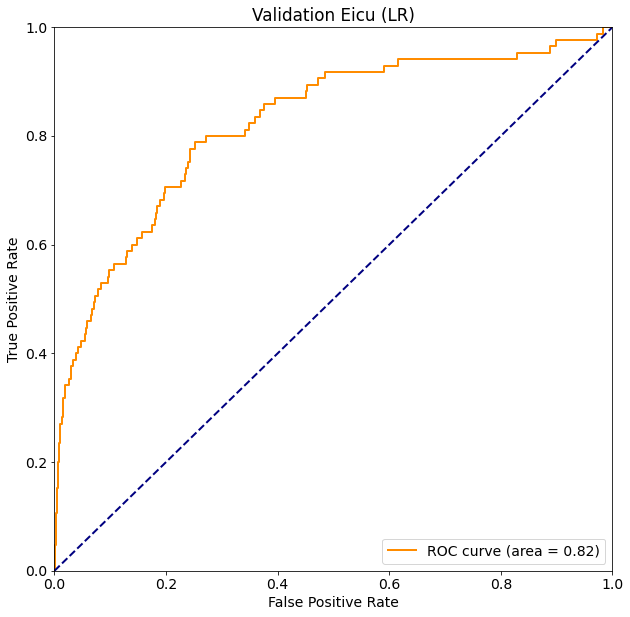

In [78]:
# Compute ROC curve and ROC area for each class
fpr,tpr,threshold = roc_curve(y_validation_old, predict_pro_old_lr) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Eicu (LR)')
plt.legend(loc="lower right")

plt.show()

predict_pro_old_lr =pd.DataFrame(predict_pro_old_lr)
#predict_pro_old.to_csv('predict.csv', index=False)

In [79]:
print('smote_accuracy:%0.2f' %smote_accuracy)
print('smote_auc:  %0.2f' %smote_roc_auc)
print('smote_sensitivity : %0.2f' %smote_sensitivity)
print('smote_specificity : %0.2f\n' %smote_specificity)

print('nr_accuracy: %0.2f' %nr_accuracy)
print('nr_auc: %0.2f' %nr_roc_auc)
print('nr_sensitivity: %0.2f' %nr_sensitivity)
print('nr_specificity: %0.2f\n' %nr_specificity)

print('5_fold_accuracy : %0.2f' %accuracy_5_fold)  #accuracy
print('5_fold_auc : %0.2f' %fold_roc_auc)  #accuracy
print('5_fold_sensitivity: %0.2f' %sensitivity_5_fold)
print('5_fold_specificity: %0.2f\n' %specificity_5_fold)

print('stacking_svm_Accuracy: %0.2f' %stacking_svm_accuracy)
print('stacking_svm_auc: %0.2f' %stacking_svm_roc_auc)
print('stacking_svm_sensitivity: %0.2f' %stacking_svm_sensitivity)
print('stacking_svm_specificity: %0.2f' %stacking_svm_specificity)
print('svm_accuracy_cxr : %0.2f' % svm_accuracy)
print('svm_auc_cxr : %0.2f' % svm_roc_auc )
print('svm_Sensitivity_cxr : %0.2f' % svm_sensitivity )
print('svm_Specificity_cxr :%0.2f\n' % svm_specificity)

print('stacking_lr_Accuracy: %0.2f' %stacking_lr_accuracy)
print('stacking_lr_auc: %0.2f' %stacking_lr_roc_auc)
print('stacking_lr_sensitivity: %0.2f' %stacking_lr_sensitivity)
print('stacking_lr_specificity: %0.2f' %stacking_lr_specificity)
print('lr_accuracy_cxr : %0.2f' % lr_accuracy)
print('lr_auc_cxr : %0.2f' % lr_roc_auc )
print('lr_Sensitivity_cxr : %0.2f' % lr_sensitivity )
print('lr_Specificity_cxr :%0.2f\n' % lr_specificity)

print('stacking_xg_Accuracy: %0.2f' %stacking_xg_accuracy)
print('stacking_xg_auc: %0.2f' %stacking_xg_roc_auc)
print('stacking_xg_sensitivity: %0.2f' %stacking_xg_sensitivity)
print('stacking_xg_specificity: %0.2f' %stacking_xg_specificity)
print('xg_accuracy_cxr : %0.2f' % xg_accuracy)
print('xg_auc_cxr : %0.2f' % xg_roc_auc )
print('xg_Sensitivity_cxr : %0.2f' % xg_sensitivity )
print('xg_Specificity_cxr :%0.2f\n' % xg_specificity)

print('stacking_rf_Accuracy: %0.2f' %stacking_rf_accuracy)
print('stacking_rf_auc: %0.2f' %stacking_rf_roc_auc)
print('stacking_rf_sensitivity: %0.2f' %stacking_rf_sensitivity)
print('stacking_rf_specificity: %0.2f' %stacking_rf_specificity)
print('rf_accuracy_cxr : %0.2f' % rf_accuracy)
print('rf_auc_cxr : %0.2f' % rf_roc_auc )
print('rf_Sensitivity_cxr : %0.2f' % rf_sensitivity )
print('rf_Specificity_cxr :%0.2f\n' % rf_specificity)

print('valid_svm_accuracy: %0.2f' %valid_svm_accuracy)
print('valid_svm_roc_auc: %0.2f' %valid_svm_roc_auc)
print('valid_svm_sensitivity: %0.2f' %valid_svm_sensitivity)
print('valid_svm_specificity: %0.2f\n' %valid_svm_specificity)

print('valid_lr_accuracy: %0.2f' %valid_lr_accuracy)
print('valid_lr_roc_auc: %0.2f' %valid_lr_roc_auc)
print('valid_lr_sensitivity: %0.2f' %valid_lr_sensitivity)
print('valid_lr_specificity: %0.2f' %valid_lr_specificity)




smote_accuracy:0.91
smote_auc:  0.72
smote_sensitivity : 0.38
smote_specificity : 0.92

nr_accuracy: 0.98
nr_auc: 0.51
nr_sensitivity: 0.00
nr_specificity: 1.00

5_fold_accuracy : 0.84
5_fold_auc : 0.74
5_fold_sensitivity: 0.49
5_fold_specificity: 0.85

stacking_svm_Accuracy: 0.83
stacking_svm_auc: 0.89
stacking_svm_sensitivity: 0.81
stacking_svm_specificity: 0.83
svm_accuracy_cxr : 0.84
svm_auc_cxr : 0.89
svm_Sensitivity_cxr : 0.84
svm_Specificity_cxr :0.84

stacking_lr_Accuracy: 0.82
stacking_lr_auc: 0.89
stacking_lr_sensitivity: 0.82
stacking_lr_specificity: 0.82
lr_accuracy_cxr : 0.83
lr_auc_cxr : 0.89
lr_Sensitivity_cxr : 0.85
lr_Specificity_cxr :0.83

stacking_xg_Accuracy: 0.84
stacking_xg_auc: 0.90
stacking_xg_sensitivity: 0.80
stacking_xg_specificity: 0.84
xg_accuracy_cxr : 0.84
xg_auc_cxr : 0.89
xg_Sensitivity_cxr : 0.82
xg_Specificity_cxr :0.84

stacking_rf_Accuracy: 0.85
stacking_rf_auc: 0.89
stacking_rf_sensitivity: 0.81
stacking_rf_specificity: 0.85
rf_accuracy_cxr : 0.85


In [80]:
#test_avg=pd.DataFrame(x_test_stacking)
#test_avg.to_csv('test_avg.csv', index=False)

In [81]:
#predict_pro_stacking_pri=pd.DataFrame(predict_pro_stacking)
#predict_pro_stacking_pri.to_csv('predict_pro_stacking_pri.csv', index=False)
